# PRÉPAREZ DES DONNÉES POUR UN ORGANISME DE SANTÉ PUBLIQUE

![](Logo-Sante-Publique-France-.png)

# Table des matières

xxxxxxxxxxxxxxxxxx à faire xxxxxxxxxxxxxxx

# Introduction

L'agence "Santé publique France" a lancé un **appel à projets pour rendre les données de santé plus accessibles**. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.

Le jeu de données à analyser est issu de la plateforme **Open Food Facts**, qui est une association donnant accès à une base données de produits alimentaires :
- ouverte à tous
- où tout le monde peut contribuer

Dans le cadre de cet appel à projets, nous :
- proposerons une idée d'application
- mènerons à bien le nettoyage nécessaire à l'exploration des données
- explorerons les données traitées

# Partie 1 - Imports & Proposition d'application

## P1.1. Imports des librairies & du dataset

Commençons par importer les principales librairies dont nous aurons besoin :

In [1]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations
import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import matplotlib.ticker as mtick # for format axis in percent %
import seaborn as sns # for data visualisation, with different proporties
import missingno as ms # for visualisation of missing data

## P1.2. Import du dataset

In [2]:
foodRaw=pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t',low_memory=False)

Nous pouvons regarder les dimensions du tableau généré :

In [3]:
print("Le tableau mis à disposition comporte ", foodRaw.shape[1], "variables et ", foodRaw.shape[0], "lignes / produits")

Le tableau mis à disposition comporte  162 variables et  320772 lignes / produits


Nous pouvons affihcer les premières lignes :

In [4]:
display(foodRaw.head())

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous avons à disposition 4 types de variables :
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : 
    - quantité en grammes d’un nutriment pour 100 grammes du produit.
    - des scores nutritionnels (comme le nutriscore)

## P1.3. Proposition d'application

Afin d'aider à améliorer la santé de nos concitoyens, nous pourrions utiliser les données mises à notre disposition pour aider les malades et les médecins.

En effet, un des principaux maux du 21$^{ème}$ est la multiplications de maladies chroniques dans nos sociétés industrialisées. Mes maladies cardiovasculaires représentent **la dépense la plus importante** pour l'Assurance Maladie.

**Hypertension, Diabètes, Cholestérol, Obésites, etc.** : Toutes ses pathologies sont, à des degrès différents, liées au régime alimentaire des malades.

En plus des médicaments, les médecins prescrivent également un **régime alimentaire adapté** aux pathologies chroniques des patients affectés.

Mais devant le nombre de produits disponibles en grandes surfaces, chacun avec une étiquette nutritionnelle qui lui est propre, le patient peut se retrouver démuni au moment de faire ses choix.

**MyHealthScore** : Une application **proposée par le médecin** à son patient pour l'aider à adapter son régime alimentaire à sa (ou ses) pathologie(s).

L'idée :
- le médecin configure le **profil** de son patient :
    - données biométriques : sexe, age, poids, taille, etc.
    - pathologie(s) : hypertension, diabètes, cholestérol, obésité, autre
    
    
- le profil permet de créé un score nutritionnel **adapté au patient** : *MyHealthScore*
    - ce score est basé sur les **mêmes données** nutritionnelles que le Nutri-Score :
        - La valeur énergétique (KJ)
        - Les lipides (g)
        - Les acides gras saturés (g)
        - Les sucres (g)
        - Les protéines (g)
        - Le sodium (mg)
        - Les fibres (g)
        - Fruits, légumes, etc. (%)
        
   mais **personnalisé** pour le profil du patient.


- l'**application** pourrait fonctionner ainsi :
    - le patient **scanne / rentre une référence** d'un produit
    - l'application **lui délivre ensuite son MyHeathScore personnalisé** selon les informations renseignées par son médecin.

- chaque système ayant ses propres spécificités, l'application serait dans un premier temps destinée au système de santé **français**.


## P1.4. Réduction du champ d'étude : France

Comme expliqué plus haut, nous allons nous concentrer sur le France dans le cadre cette étude.



Le dataset comporte plusieurs colonnes contenant des informations sur le pays :

In [5]:
# create a list with "coutries" columns
countriesColNames = [col for col in foodRaw.columns if "countri" in col]
countriesColNames

['countries', 'countries_tags', 'countries_fr']

Avant d'en sélectionner une pour notre filtrage, regardons à quoi elles ressemblent :

In [6]:
foodRaw[countriesColNames].sample(10)

,countries,countries_tags,countries_fr
17084,US,en:united-states,États-Unis
104283,US,en:united-states,États-Unis
14045,US,en:united-states,États-Unis
231851,en:FR,en:france,France
216057,France,en:france,France
202646,France,en:france,France
176088,France,en:france,France
163021,US,en:united-states,États-Unis
283262,en:FR,en:france,France
30025,US,en:united-states,États-Unis


Nous pouvons nous concentrer sur la colonne "countries_fr".

Regardons le nombre de valeurs manquantes pour ces trois colonnes :

In [7]:
foodRaw[countriesColNames].isna().sum()

countries         280
countries_tags    280
countries_fr      280
dtype: int64

Elles n'en contiennent. Si elle ne sont pas positionnées aux mêmes endroits, nous pouvons regarder si "countries" et "countries_tags" peuvent nous aider à imputer "countries_fr" :

In [8]:
# create a mask for rows where "countries_fr" is NaN and one of the others is not
maskCountries = (foodRaw.countries_fr.isna())&((foodRaw.countries_tags.notna())|(foodRaw.countries.notna()))

foodRaw[countriesColNames].loc[maskCountries]

,countries,countries_tags,countries_fr


Les autres colonnes ne peuvent donc pas nous aider à combler les 280 valeurs manquantes. Nous ne considérerons pas ces produits.

Regardons maintenant les différents pays contributeurs de la base de données :

In [9]:
# list of unique values in "countries_fr" and number of occurrences
foodRaw.countries_fr.value_counts(ascending=False)

États-Unis                                      172998
France                                           94392
Suisse                                           14953
Allemagne                                         7870
Espagne                                           5009
                                                 ...  
Danemark,Suisse,en:Deutschland,en:Frankreich         1
France,Luxembourg,Suisse                             1
Autriche,République tchèque,Allemagne                1
Allemagne,Hongrie                                    1
Chine,Hong Kong                                      1
Name: countries_fr, Length: 722, dtype: int64

Les valeurs de cette variable contiennent, en chaîne de caractères, la liste des pays où le produit est commercialisé.

Afin de nous concentrer sur la france, nous allons donc rechercher dans ces chaînes de caractères :

In [10]:
# create masks for french products 
maskFrance = foodRaw.countries_fr.str.find("France")!=-1
maskfrance = foodRaw.countries_fr.str.find("france")!=-1
maskFr = foodRaw.countries_fr.str.find("Fr")!=-1
maskFR = foodRaw.countries_fr.str.find("FR")!=-1
maskfr = foodRaw.countries_fr.str.find("fr")!=-1

Testons ces différents filtres.

In [11]:
foodRaw.loc[maskFrance,"countries_fr"].value_counts()

France                                                   94392
France,Suisse                                             1224
France,Royaume-Uni                                         514
Belgique,France                                            512
France,Allemagne                                           240
                                                         ...  
Belgique,France,Allemagne,Roumanie                           1
Australie,République tchèque,France,Allemagne,Hongrie        1
Danemark,France,Allemagne,Russie,Espagne,Royaume-Uni         1
République tchèque,Danemark,France,Allemagne                 1
France,Hong Kong                                             1
Name: countries_fr, Length: 305, dtype: int64

On obtient 305 valeurs uniques en recherchant avec "France". Continuons :

In [12]:
foodRaw.loc[maskfrance,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Cette orthographe n'est pas utilisée. Continuons :

In [13]:
foodRaw.loc[maskFr&~maskFrance,"countries_fr"].value_counts()

Suisse,Deutschland,Frankreich                                                                                                9
Suisse,Frankrijk,Nederland                                                                                                   2
Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Portugalia,es:Spanyolorszag                            1
Belgique,Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Nemetorszag,es:Portugalia,es:Spanyolorszag    1
Suisse,Deutschland,Frankreich,Spanien                                                                                        1
Suisse,Frankrijk                                                                                                             1
Suisse,Belgien,Deutschland,Frankreich                                                                                        1
Danemark,Suisse,en:Deutschland,en:Frankreich                                                                   

France est orthographié différemment.

In [14]:
foodRaw.loc[maskfr&~maskFrance,"countries_fr"].value_counts()

Polynésie française               52
Afrique du Sud                    36
en:fruit-yogurts                   8
Polynésie française,États-Unis     3
Polynésie française,Suisse         1
République centrafricaine          1
Name: countries_fr, dtype: int64

In [15]:
# create a mask for "Polynésie française"
maskPolyFr = foodRaw.countries_fr.str.find("Polynésie française")!=-1

In [16]:
foodRaw.loc[maskFR,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Ce dernier mask n'a rien donné. Nous pouvons donc filtrer notre dataframe pour ne conserver que les produits commercialisés en France : 

In [17]:
foodRawFr = foodRaw.copy()
#apply selected masks
foodRawFr = foodRawFr.loc[maskFrance|maskFr|maskPolyFr]

Voici les nouvelles dimensions du dataframe :

In [18]:
foodRawFr.shape

(98800, 162)

## P1.5. Sélection des variables

Pour fonctionner, l'application ferait appel à la base de données d'OpenFoodFact pour récupérer les données nutritionnelles et calculer le MyHealthScore du patient.

Il faut pour cela que les données soient présentes. Regardons visuellement le niveau de remplissage du dataset. Pour cela nous allons utiliser la librairie `missingno` :

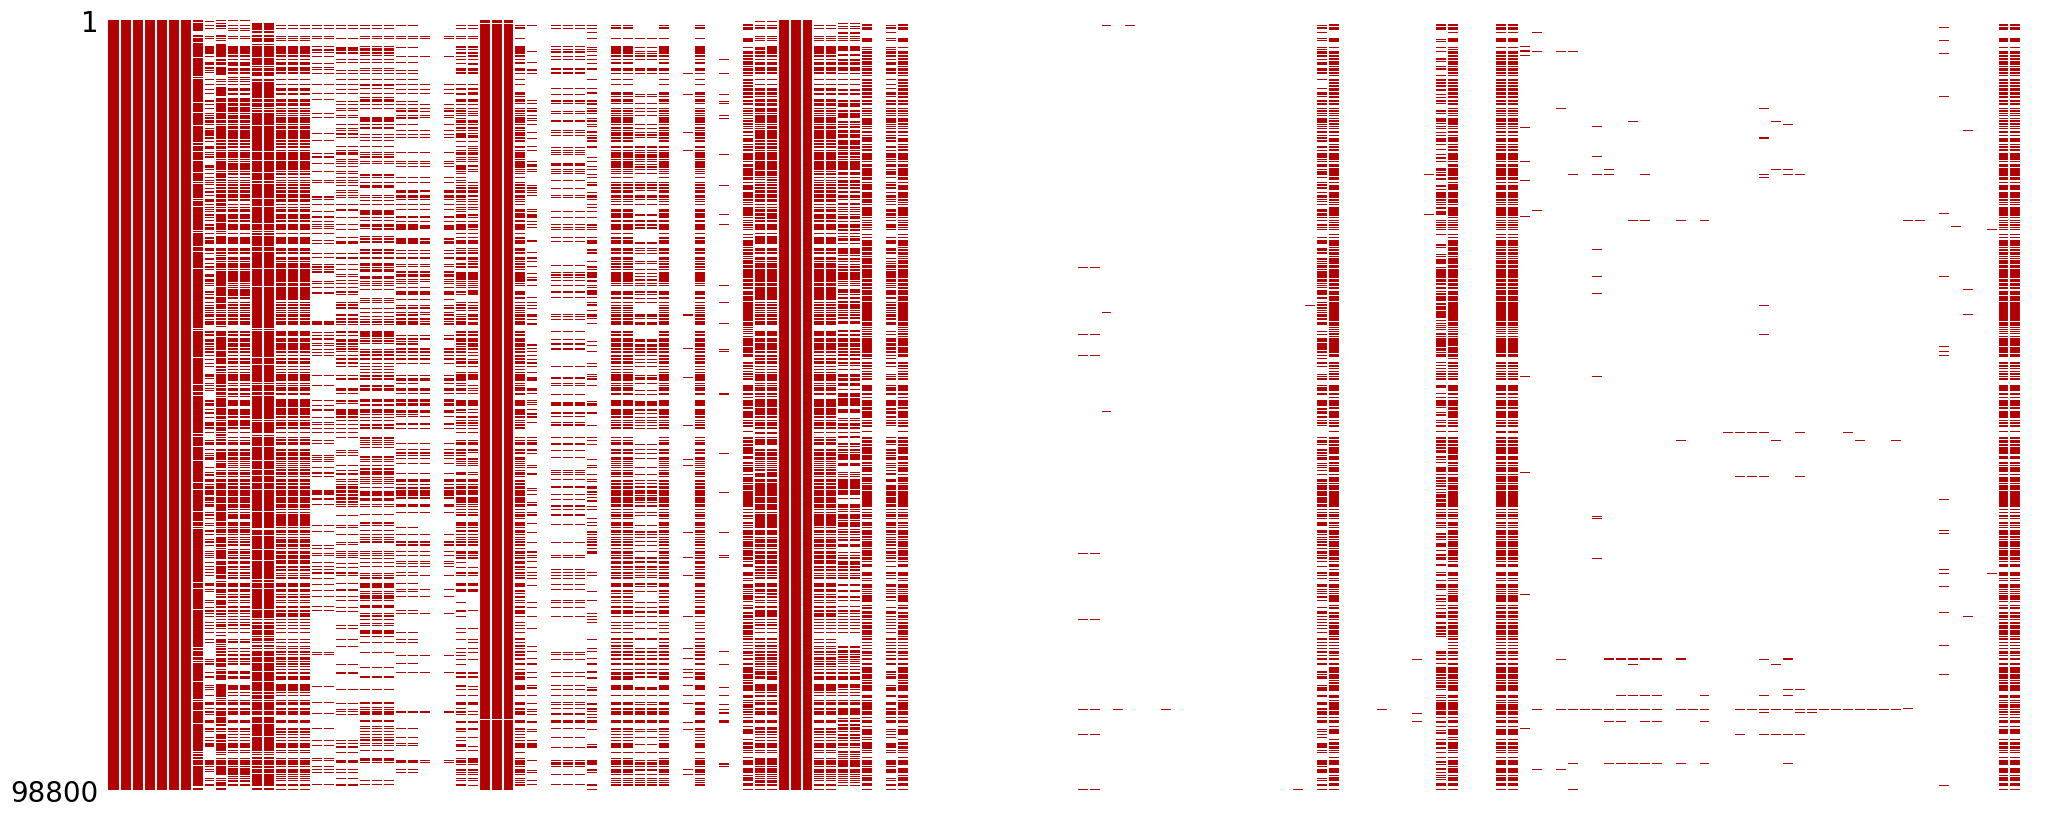

In [19]:
ms.matrix(foodRawFr,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

Le dataset est globalement **très peu renseigné**.

Nous pouvons regarder ce qu'il en est des features qui nous intéressent pour calculer, théoriquement, un MyHealthScore :

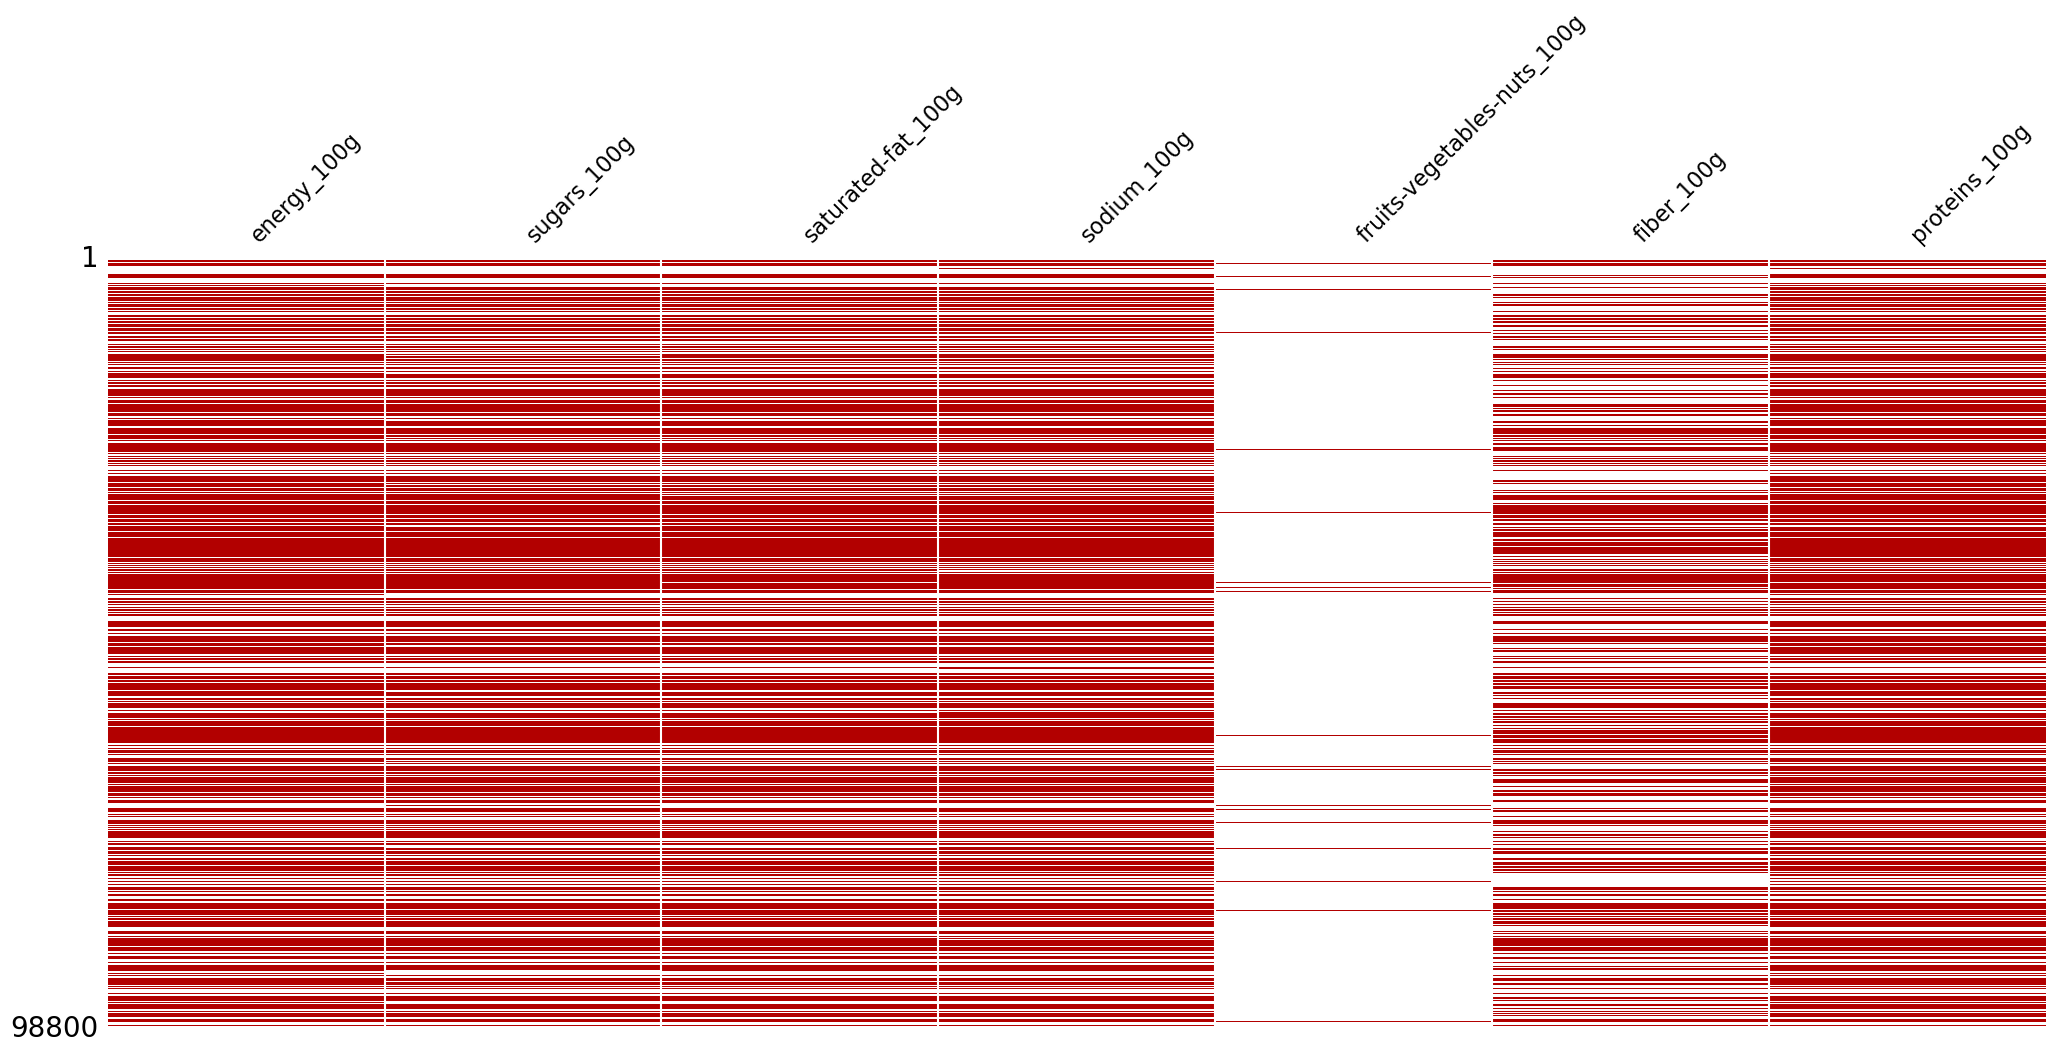

In [20]:
theoricalFeaturesNames=["energy_100g","sugars_100g","saturated-fat_100g","sodium_100g","fruits-vegetables-nuts_100g","fiber_100g","proteins_100g"]
ms.matrix(foodRawFr[theoricalFeaturesNames],color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

Malheureusement la feature concernant les **fruits et légumes** est **très peu renseignée**...

Or celle-ci se révèle indispensable pour calculer un MyHealthScore reflétant correctement les recommandations médicales.

Par exemple, si l'on regarde les **préconisations hygiéno-ditétiques pour les personnes atteinte d'hypertension**, le site internet de la **CPAM indique** :
- sel : < 6g /j
- perdre du poids, soit via une IMC < 25 kg/m², soit en perdant 10% du poids initial
- activité physique, soit 30 min/j, soit 3x / semaine
- réduire consommation d'alcool
- augmenter la consommation de **fruits et légumes**
- réduire la consommation de graisses saturées
- arrêter le tabac

La construction d'un MyHealthScore devra donc passer par la prise en compte d'autres colonnes. Pour les déterminer, nous pourrons nous baser dans un premier temps sur le "taux de vide". Regardons ce que cela donne pour les colonnes `theoricalFeaturesNames` :

In [21]:
# percentage of null values in primal selected features :
(foodRawFr[theoricalFeaturesNames].isna().mean()*100).round(1).astype(str)+" %"

energy_100g                    34.5 %
sugars_100g                    36.6 %
saturated-fat_100g             36.8 %
sodium_100g                    36.6 %
fruits-vegetables-nuts_100g    97.0 %
fiber_100g                     53.7 %
proteins_100g                  34.8 %
dtype: object

Écrivons une fonction pour filtrer les colonnes en fonction de leur taux de valeurs manquantes :

In [22]:
def dropEmptyCols(df,emptinessThreshold=1) :
    
    """return an input pandas.DataFrame without its empty columns
    
    inputs
    ------
    df : pandas.DataFrame object
    
    optional inputs 
    ---------------
    emptinessThreshold : float, defaul : = 1. Gives the limit threshold of emptiness. 
    if >=threshold, column is dropped. 
    
    returns
    -------
    dfWithoutEmptyCols : pandas.DataFrame object, the same one without its empty columns
    
    """
    #select columns with percentage of null values > threshold
    emptyColsNames=df.isna().mean().loc[df.isna().mean()>=emptinessThreshold].index 
    
    #drop selected columns
    dfWithoutEmptyCols=df.copy()
    dfWithoutEmptyCols = dfWithoutEmptyCols.drop(columns=emptyColsNames)
    
    return dfWithoutEmptyCols

Nous avons d'ores et déjà fait une croix sur `fruits-vegetables-nuts_100g`. Basons-nous sur le taux de `fiber_100g` :

In [23]:
foodWithout_54=dropEmptyCols(foodRawFr,emptinessThreshold=0.54)

In [24]:
# check percentage of null values in foodWithout_54
(foodWithout_54.isna().mean().sort_values()*100).round(2).astype(str)+" %"

code                                         0.0 %
url                                          0.0 %
creator                                      0.0 %
created_t                                    0.0 %
last_modified_t                              0.0 %
last_modified_datetime                       0.0 %
created_datetime                             0.0 %
states                                      0.02 %
states_tags                                 0.02 %
states_fr                                   0.02 %
countries                                   0.28 %
countries_tags                              0.28 %
countries_fr                                0.28 %
product_name                                7.36 %
brands                                     12.29 %
brands_tags                                 12.3 %
quantity                                   27.66 %
pnns_groups_2                              31.95 %
pnns_groups_1                              34.14 %
energy_100g                    

N'ayant pas à notre disposition la teneur en fruits et légumes, nous pouvons nous baser sur le Nutri-Score, qui prend en compte celle-ci dans son calcul.

A partir du Nutri-Score, il sera possible dans le cadre du développement de l'application, de créer un MyHealthScore en adaptant les pondérations des autres valeurs nutritionnelles.

On peut donc sélectionner les variables suivantes pour notre analyse :
- `code`, `product_name` et `brands` pour identitifer les produits
- `nutrition-score-fr_100g` qui correspond au socre nutritionnel
- `nutrition_grade_fr` qui correspond au Nutri-Score, l'échelle graphique scindant le score nutritionnel en 5 classes A, B, C, D et E
- `energy_100g`
- `proteins_100g`
- `fiber_100g`
- `sodium_100g` et `salt_100g`, ("salt" est liée à "sodium" par un facteur 2.5. Nous nous servirons de cette variable pour un traitement en particulier, puis nous l'écarterons) 
- `sugars_100g` et `carbohydrates_100g`
- `saturated-fat_100g` et `fat_100g`
- `pnns_groups_2` et `pnns_groups_1` qui permettent de classifier les produits dans des catégories plus ou moins précises

In [25]:
# select work features
workFeatures=["code",
               "product_name",
               "brands",
               "pnns_groups_1",
               "pnns_groups_2",
               "nutrition-score-fr_100g",
               "nutrition_grade_fr",
               "salt_100g",
               "carbohydrates_100g",
               "fat_100g"]+theoricalFeaturesNames
workFeatures.remove("fruits-vegetables-nuts_100g")

In [26]:
foodRawLight = foodRawFr.copy()
foodRawLight = foodRawLight[workFeatures]
foodRawLight

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutrition-score-fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated-fat_100g,sodium_100g,fiber_100g,proteins_100g
0,0000000003087,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,Filet de bœuf,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,0000000036252,Lion Peanut x2,Sunridge,unknown,unknown,22.0,e,0.09652,70.0,20.0,1883.0,57.5,12.5,0.038,2.5,2.5
136,0000000039259,Twix x2,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,Roussette du Bugey (2011),Roussette du Bugey,NaN,Alcoholic beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,Thé vert Earl grey,Lobodis,Beverages,Non-sugared beverages,2.0,c,0.02540,0.5,0.2,21.0,0.5,0.2,0.010,0.2,0.5
320764,9918,"Cheese cake thé vert, yuzu",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,Rillette d'oie,"Sans marque,D.Lambert",Fish Meat Eggs,Processed meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut afficher de nouveau la visualisation des valeurs manquantes :

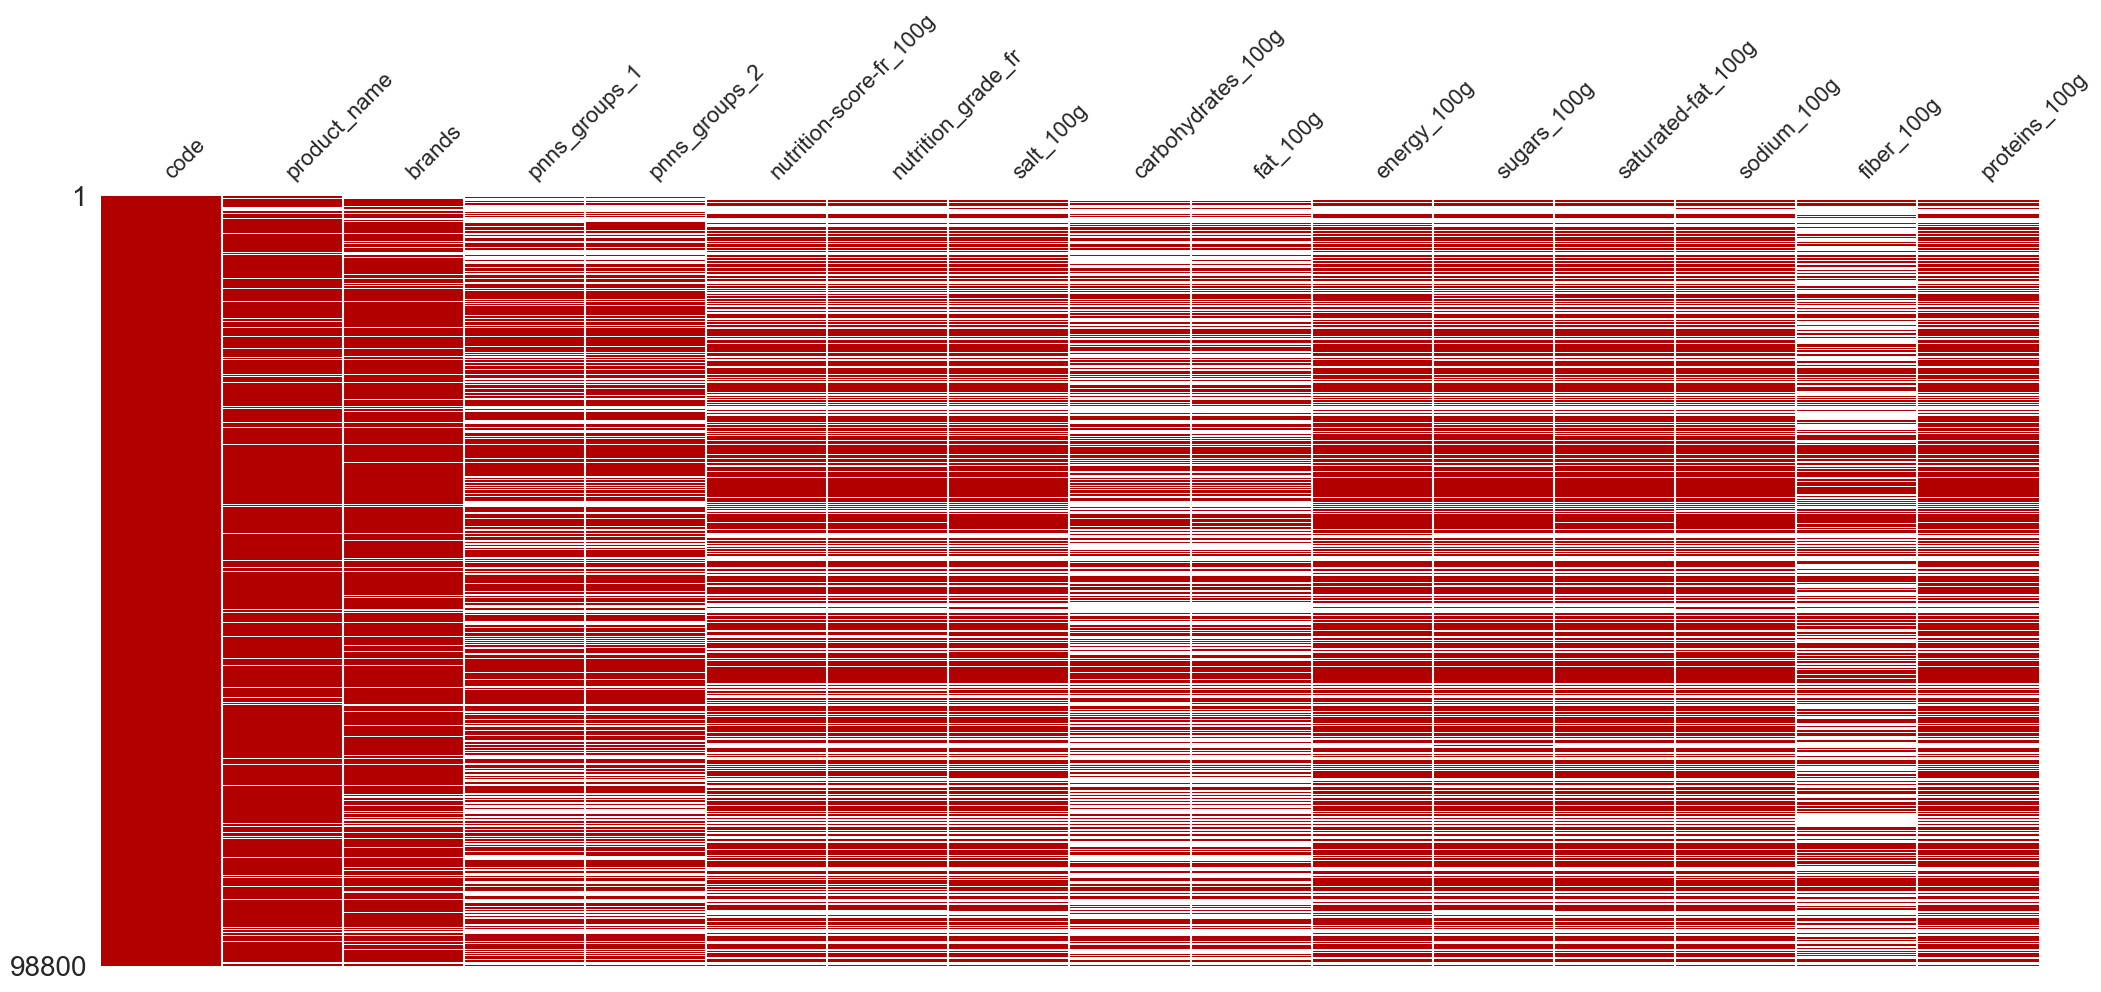

In [106]:
ms.matrix(foodRawLight,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

# Partie 2 - Nettoyage

## P2.1. Nommage des colonnes

Pour faciliter le traitement, nous renommons certaines colonnes pour supprimer les "-" et les remplacer par des "_" :

In [27]:
# use only underscore for column names

foodRawLightUnder=foodRawLight.copy() # create a copy
foodRawLightUnder.rename(columns={col : col.replace("-","_") for col in foodRawLightUnder.columns}, # replace "-" by "_"
                         inplace=True
                        )
workFeatures=foodRawLightUnder.columns.tolist()

## P2.2. Éliminer les doublons

Pour repérer les produit présents deux fois, nous pouvons dans un premier temps regarder la colonne "code".

### P2.2.1. Des produits en double ? "code"

In [28]:
foodRawLightUnder.code.sample(5)

216760    3263859448516
213855    3259011121175
236365    3515451060031
239626    3560070809264
187361    3017232001009
Name: code, dtype: object

le format du code à l'air d'être une suite de 13 chiffres.
Cependant le type "object" de la Series interroge.

In [29]:
# looking to the lenght of "code" values for formatting issues
foodRawLightUnder.code.str.len().value_counts(dropna=False).sort_index()

1         2
2         1
3         2
4         6
5        10
6        32
7        38
8      6186
9         6
10       33
11       30
12       36
13    92329
14       51
15       23
16        3
17        1
22        1
24        4
25        1
31        1
32        2
40        1
41        1
Name: code, dtype: int64

Après quelques recherches, les deux formats les plus représentés correspondent aux systèmes EAN 8 et EAN 13 (EAN pour *European Article Numbering*). Ces deux systèmes sont les plus utilisés en Europe.

Nous faisons le choix de nous séparer des 285 produits aux codes barres non formatés EAN 8 ou 13 : l'usage principal du MyHealthScore se fera via l'application et le scan de code barre.

In [30]:
foodClean01=foodRawLightUnder.copy()
# keep only the values of "code" whose length is 8 or 13
foodClean01=foodClean01.loc[(foodClean01.code.str.len()==8)|(foodClean01.code.str.len()==13)]

Nous pouvons maintenant regarder s'il y a des produits en double :

In [31]:
#look for duplicates in column "code"
foodClean01.loc[foodClean01.code.duplicated(keep=False)]

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutrition_score_fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g


Il ne semble pas y avoir de produits différents utilisant le même code-barre.

Une autre manière de repérer les doublons et de regarder la colonne "product_name".

### P2.2.2. Des produits en double ? "product_name" 

Nous n'avons que des produits au code-barre unique. Mais le même produit a pu être étiqueté avec 2 code-barres différents. Regardons.

In [32]:
foodClean01.product_name.value_counts()

Huile d'olive vierge extra        62
Mayonnaise                        54
Moutarde de Dijon                 49
Orange                            46
Spaghetti                         46
                                  ..
3 Œufs avec surprise               1
20 saucisses de Strasbourg         1
Gelée extra Mûre                   1
noir Eclats de fèves 72% cacao     1
Tomates aux Vermicelles            1
Name: product_name, Length: 74413, dtype: int64

Nous ne sommes pas assez précis. Nous ne pouvons pas considérer seulement "product_name" pour rechercher les doublons. Regardons également "brands".

### P2.2.3. Des produits en double ? "product_name" ET "brands"

Regardons si des noms de produits sont présents plusieurs fois sous la même marque :

In [33]:
# look in non null values for "product_name","brands" and "code" for products with the same name and brand :
foodClean01[["product_name","brands",'code']].loc[foodClean01[["product_name","brands",'code']].notna().all(axis=1)].groupby(['product_name',"brands"]).count().sort_values("code",ascending=False).head(10)

,,code
product_name,brands,
Coca-Cola,Coca-Cola,20
Pom'potes,Materne,15
Nutella,"Ferrero,Nutella",14
Orangina,Orangina,14
Nesquik,"Nestlé,Nesquik",11
Perrier,Perrier,11
Auchan,Auchan,10
Nutella,Ferrero,10
Mousline,Maggi,9


Il y a donc des doublons. Ceux-ci peuvent être expliqués par :
- un même produit rentré plusieurs fois sous des codes différents
- un même produit avec des quantités différentes (un pack de 6 bouteilles versus une bouteille seule)

Le score n'a pas vocation à prendre en compte la quantité. Ce sont les qualités intrinsèques du produit, pour 100g en l'occurrence, qui nous intéressent.

Nous allons donc supprimer ces doublons.

In [34]:
foodClean02=foodClean01.copy()
foodClean02=foodClean02.loc[
    (foodClean02[["product_name","brands"]].isna().any(axis=1)) # be carefull to keep the rows where "product_name" or "brands" is NaN
    | # or :
    ~(foodClean02[["product_name","brands"]].duplicated(subset=["product_name","brands"],keep='last')) # non duplicated values for both features
]

In [35]:
print("On a retiré ",foodClean01.shape[0]-foodClean02.shape[0]," produits considérés comme doublons")

On a retiré  3105  produits considérés comme doublons


### P2.2.3. BIS (A SUPPRIMER) Check avec "quantity"

"quantity" n'était pas très remplie, mais réintégrons là provisoirement pour voir ce qu'il en est.


In [36]:
checkQtDf=foodClean01.copy()

In [37]:
checkQtDf["quantity"]=foodRawFr.quantity.loc[checkQtDf.index]

In [38]:
checkQtDf[["product_name","brands","quantity","code"]].loc[checkQtDf[["product_name","brands","quantity","code"]].notna().all(axis=1)].groupby(["product_name","brands","quantity"]).count().sort_values("code",ascending=False).head(20)

code
product_name                      brands               quantity        
Pâte à Sucre                      Sainte Lucie         100 g          6
Framboises                        Driscoll's           125 g          5
Riz long grain                    Carrefour            1 kg           3
Thaï                              Casino               500 g          3
Penne Rigate                      Panzani              500 g          3
Barre énergie                     FENIOUX              35g            3
Coca-Cola                         Coca-Cola            4 * 250 ml     3
                                                       50 cl          3
Macaroni                          Panzani              500 g          3
Fusilli                           La Bio Idea          500 g          3
La Croix des Grèves Mt. St-Michel Brasserie de la Baie 33 cl          3
Camembert d'Isigny (22% MG)       Isigny Ste Mère      250 g          3
Mayonnaise de Dijon               Amora                470 g          3
Le beurre tendre                  Elle & Vire          250 g          3
Pom'potes                         Materne              90g            3
100% Mie Nature                   Harrys               500 g          3
Haricots verts extra fins         Auchan               220 g          3
Confipote                         Materne              350 g          3
Maxi Jac' Complet                 Jacquet              550 g          3
Corn Flakes                       Kellogg's            500 g          3

La quantité rentre donc bien en jeu. Les "vrais" doublons sont moins nombreux. Il existe des produits dans la base de données renseignés avec plusieurs quantités différentes.

In [39]:
checkQtDf=checkQtDf.loc[
    (checkQtDf[["product_name","brands","quantity"]].isna().any(axis=1)) | # be carefull to keep the rows where "product_name" or "brands" is NaN
    ~(checkQtDf[["product_name","brands","quantity"]].duplicated(subset=["product_name","brands","quantity"],keep='last')) # 
]

In [40]:
print("On aurait retiré ",foodClean01.shape[0]-checkQtDf.shape[0]," produits")

On aurait retiré  316  produits


## P2.3. Traiter les outliers

On sait que les outliers ont un imppact négatif sur la moyenne et l'écart type empiriques de nos variables. Avant de nous concentrer sur l'imputation des valeurs manquantes, il faut d'abord traiter ces outliers. Regardons dans un premiers temps les valeurs min et max des variables numériques :

In [41]:
foodClean02.describe()

,nutrition_score_fr_100g,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
count,59076.000000,60197.000000,45154.000000,45585.000000,6.215600e+04,60145.000000,60007.000000,60194.000000,44059.000000,61881.000000
mean,8.676366,1.162005,27.839665,13.293629,1.174376e+03,13.396842,5.451226,0.457503,2.576606,7.787648
std,9.038369,4.261100,27.348395,16.752498,1.308400e+04,19.010655,8.554641,1.677578,4.682310,7.889584
min,-15.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.080000,4.100000,1.400000,4.310000e+02,1.000000,0.300000,0.031496,0.000000,1.900000
50%,9.000000,0.560000,14.900000,7.000000,1.037000e+03,4.000000,2.000000,0.220472,1.400000,6.000000
75%,15.000000,1.250000,53.000000,21.000000,1.648000e+03,17.860000,7.500000,0.492126,3.200000,11.000000
max,40.000000,211.000000,190.000000,380.000000,3.251373e+06,105.000000,210.000000,83.000000,178.000000,100.000000


On peut remarquer que :
- il y a des valeurs **négatives** pour les features "nutrition_score_fr_100g", ce qui est normal, et pour **"sugars_100g"**, ce qui devra être traîté
- les valeurs maximales pour les valeurs nutritionnelles " *..._100g* " classiques (hors score nutritionnel et énergie) comportent des irrégularités car **certaines sont supérieures à 100g**...
- après quelques recherches, la quantité maximale d'énergie pour 1g est de 37 kJ/g. Donc théoriquement les valeurs de la colonne **"energy_100g" ne peuvent pas dépasser 3700**, là où le maximum est de 3 251 373... L'écart-type est du coup vraiment impacté : 13084...

Pour la suite de l'étude, on ne considérera pas ces observations.

D'autres opérations de nettoyage seront également menées, cette fois basées sur le contexte métier.

### P2.3.1. Masse de sucre négative


In [42]:
# exclude products whose "sugars_100g" <0

foodClean03=foodClean02.copy()
foodClean03=foodClean03.loc[~(foodClean03.sugars_100g<0)]

In [43]:
print("On a retiré ",foodClean02.shape[0]-foodClean03.shape[0]," produits dont un des composants pesait plus de 100g")

On a retiré  1  produits dont un des composants pesait plus de 100g


### P2.3.2. Poids des constituants pour 100g supérieurs à 100g 


Sélectionnons tout d'abord les features à traiter :

In [44]:
# first, look a columns types
foodClean03.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [45]:
# select numerical columns
componentFeatures=foodClean03.select_dtypes("float64").columns.tolist()
componentFeatures

['nutrition_score_fr_100g',
 'salt_100g',
 'carbohydrates_100g',
 'fat_100g',
 'energy_100g',
 'sugars_100g',
 'saturated_fat_100g',
 'sodium_100g',
 'fiber_100g',
 'proteins_100g']

In [46]:
# exclude "non component" columns
componentFeatures.remove("nutrition_score_fr_100g")
componentFeatures.remove("energy_100g")

In [47]:
# exclude products whose component "..._100g" is above 100 :
foodClean04=foodClean03.copy()
foodClean04=foodClean04.loc[~((foodClean03[componentFeatures]>100).any(axis=1))]

In [48]:
print("On a retiré ",foodClean03.shape[0]-foodClean04.shape[0]," produits dont un des composants pesait plus de 100g")

On a retiré  12  produits dont un des composants pesait plus de 100g


### P2.3.3. Énergie pour 100g supérieure à 3700 kJ.


In [49]:
# exclude product with energy_100g > 3700

foodClean05=foodClean04.copy()
foodClean05=foodClean05.loc[~(foodClean04.energy_100g>3700)]

In [50]:
print("On a retiré ",foodClean04.shape[0]-foodClean05.shape[0]," produits dont l'énergie était supérieure à 3700 kJ")

On a retiré  252  produits dont l'énergie était supérieure à 3700 kJ


### P2.3.4. Sommes des masses des constituants PRINCIPAUX VS 100g

On peut aussi s'interroger sur les constituants dans leur ensemble. En effet, la somme des différents constituants "..._100g" ne devrait pas faire plus de 100g.

La question est de savoir quels constituants sommer. En effet certains sont des sous-produits d'autres constituants...

Après un peu de recherche (source https://ciqual.anses.fr/#/cms/questions-reponses/node/23), les "macro-constituants", dont la somme est censée être égale à 100, sont les suivant : **protéines, glucides totaux, lipides, alcool, cendres et eau**. Balayons ces différents éléments :

- proteins_100g : ok
- carbohydrates_100g : ok
- fat_100g : ok
- alcohol_100g : a été retiré du dataframe... Nous pouvons le réintégrer provisoirement
- cendres : correspondent au minéraux. Il ne nous reste que le sodium (sel)
- eau : ne fait pas partie de nos données

Nous allons nous concentrer sur les composants principaux à notre disposition. **Si la somme de ces masses est supérieure à 100g, et ce même sans les informations manquantes (on pense notamment à l'eau), alors nous écarterons le produit en question.**

In [51]:
# main nutrients column names 
macroNutCols=[
    'alcohol_100g',
    'proteins_100g',
    'carbohydrates_100g',
    'fat_100g',
    'salt_100g'
]

# create a dataframe with "alcohol_100g" back in
foodClean_WithAlcohol=foodClean05.copy()
foodClean_WithAlcohol['alcohol_100g']=foodRaw.loc[foodClean_WithAlcohol.index,"alcohol_100g"]

In [52]:
# create a mask with sum of macroNutCols > 100
mask_MacroAbove100=foodClean_WithAlcohol[macroNutCols].sum(axis=1)>100

In [53]:
# exclude products
foodClean06=foodClean05.copy()
foodClean06=foodClean06.loc[~mask_MacroAbove100]

In [54]:
print("On a retiré ",foodClean05.shape[0]-foodClean06.shape[0]," produits dont la somme des ..._100g faisait plus de 100g")

On a retiré  124  produits dont la somme des ..._100g faisait plus de 100g


Maintenant que nous avons utilisé "Salt_100g", **nous pouvons nous en séparer**. Vérifions tout de même elle pourrait servir à imputer "sodium_100g" :

In [55]:
# check if there are products with null values for "salt" and non-null value for "sodium", and vice versa
foodSaltOrSodium=foodClean06[["salt_100g","sodium_100g"]].loc[(foodClean06.salt_100g.notna())^(foodClean06.sodium_100g.notna())]
foodSaltOrSodium

,salt_100g,sodium_100g
192840,0.1016,NaN
254025,0.0000,NaN
282383,0.0254,NaN


Il n'y a que trois valeurs. Imputons-les tout rapidement :

In [56]:
# impute these 3 "sodium_100g" null values with "salt_100g"  divided by 2.5
foodClean06.loc[foodSaltOrSodium.index,"sodium_100g"]=foodClean06.loc[foodSaltOrSodium.index,"salt_100g"]/2.5

foodClean06.loc[foodSaltOrSodium.index][["sodium_100g","salt_100g"]]

,sodium_100g,salt_100g
192840,0.04064,0.1016
254025,0.00000,0.0000
282383,0.01016,0.0254


In [57]:
# remove "salt_100g"
workFeatures.remove("salt_100g")

In [58]:
foodClean06=foodClean06[workFeatures]

### P2.3.5. Masse d'un sous-composant > macro-composant

Sur le même principe, un sous-produit ne devrait pas avoir une masse supérieure à celle du produit principal.

Si l'on se concentre sur nos features, voici les comparaisons à mener :
- "sugars_100g" > "carbohydrates_100g"
- "saturated_fat_100g" > "fat_100g"

In [59]:
# create a mask with subcomponent > main component

thresholdRate=1.05
mask_MicroAboveMacro=(
    ((foodClean06['saturated_fat_100g']>foodClean06["fat_100g"]*thresholdRate)&(foodClean06["fat_100g"].notna()))
    |
    ((foodClean06['sugars_100g']>foodClean06['carbohydrates_100g']*thresholdRate)&(foodClean06['carbohydrates_100g'].notna()))
)

In [60]:
# exclude products
foodClean07=foodClean06.copy()
foodClean07=foodClean07.loc[~mask_MicroAboveMacro]

In [61]:
print("On a retiré ",foodClean06.shape[0]-foodClean07.shape[0]," produits dont la masse d'un sous-constituant dépassait celle du constituant principal")

On a retiré  150  produits dont la masse d'un sous-constituant dépassait celle du constituant principal


### P2.3.6. Traitement des outliers, impact sur la moyenne et l'écart-type

La moyenne est l'écart-type sont sensibles aux outliers. Nous pouvons regarder si les traitements précédents ont eu un effet positif.

Pour cela nous allons étudier l'évolution de ces statistiques au fil des étapes de nettoyage.

In [62]:
# put the different foodClean## in a list
listFoodCleanDfs = [
    foodClean02,
    foodClean03,
    foodClean04,
    foodClean05,
    foodClean06,
    foodClean07
]

# list of names of numerical features
numericalFeatureNames=foodClean07.select_dtypes("float64").columns.tolist()
numericalFeatureNames.remove("energy_100g")
numericalFeatureNames.append("energy_100g") # put "energy_100g" at the end of the list

# list of lists to store the empirical means of each numerical feature, for each cleaned dataframe
listOfMeans=[
    [listFoodCleanDfs[i][col].mean() for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
]

# list of lists to store the empirical stds of each numerical feature, for each cleaned dataframe
listOfStds=[
    [listFoodCleanDfs[i][col].std(ddof=1) for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
] 

In [78]:
# lists to store the evolution between each cleaning stage
listEvolOfStd=[
    [(listOfStds[i+1][idxcol]-listOfStds[i][idxcol])/listOfStds[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listFoodCleanDfs)-1)
]

listEvolOfMean=[
    [(listOfMeans[i+1][idxcol]-listOfMeans[i][idxcol])/listOfMeans[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listOfMeans)-1)
]

# cum sum
cumSumEvolOfStd=np.cumsum(listEvolOfStd,axis=0)
cumSumEvolOfMean=np.cumsum(listEvolOfMean,axis=0)

Pour une meilleure interprétation, nous allons représenter ces évolutions sur des graphiques :

In [85]:
sns.color_palette("Paired")[4]

(0.984313725490196, 0.6039215686274509, 0.6)

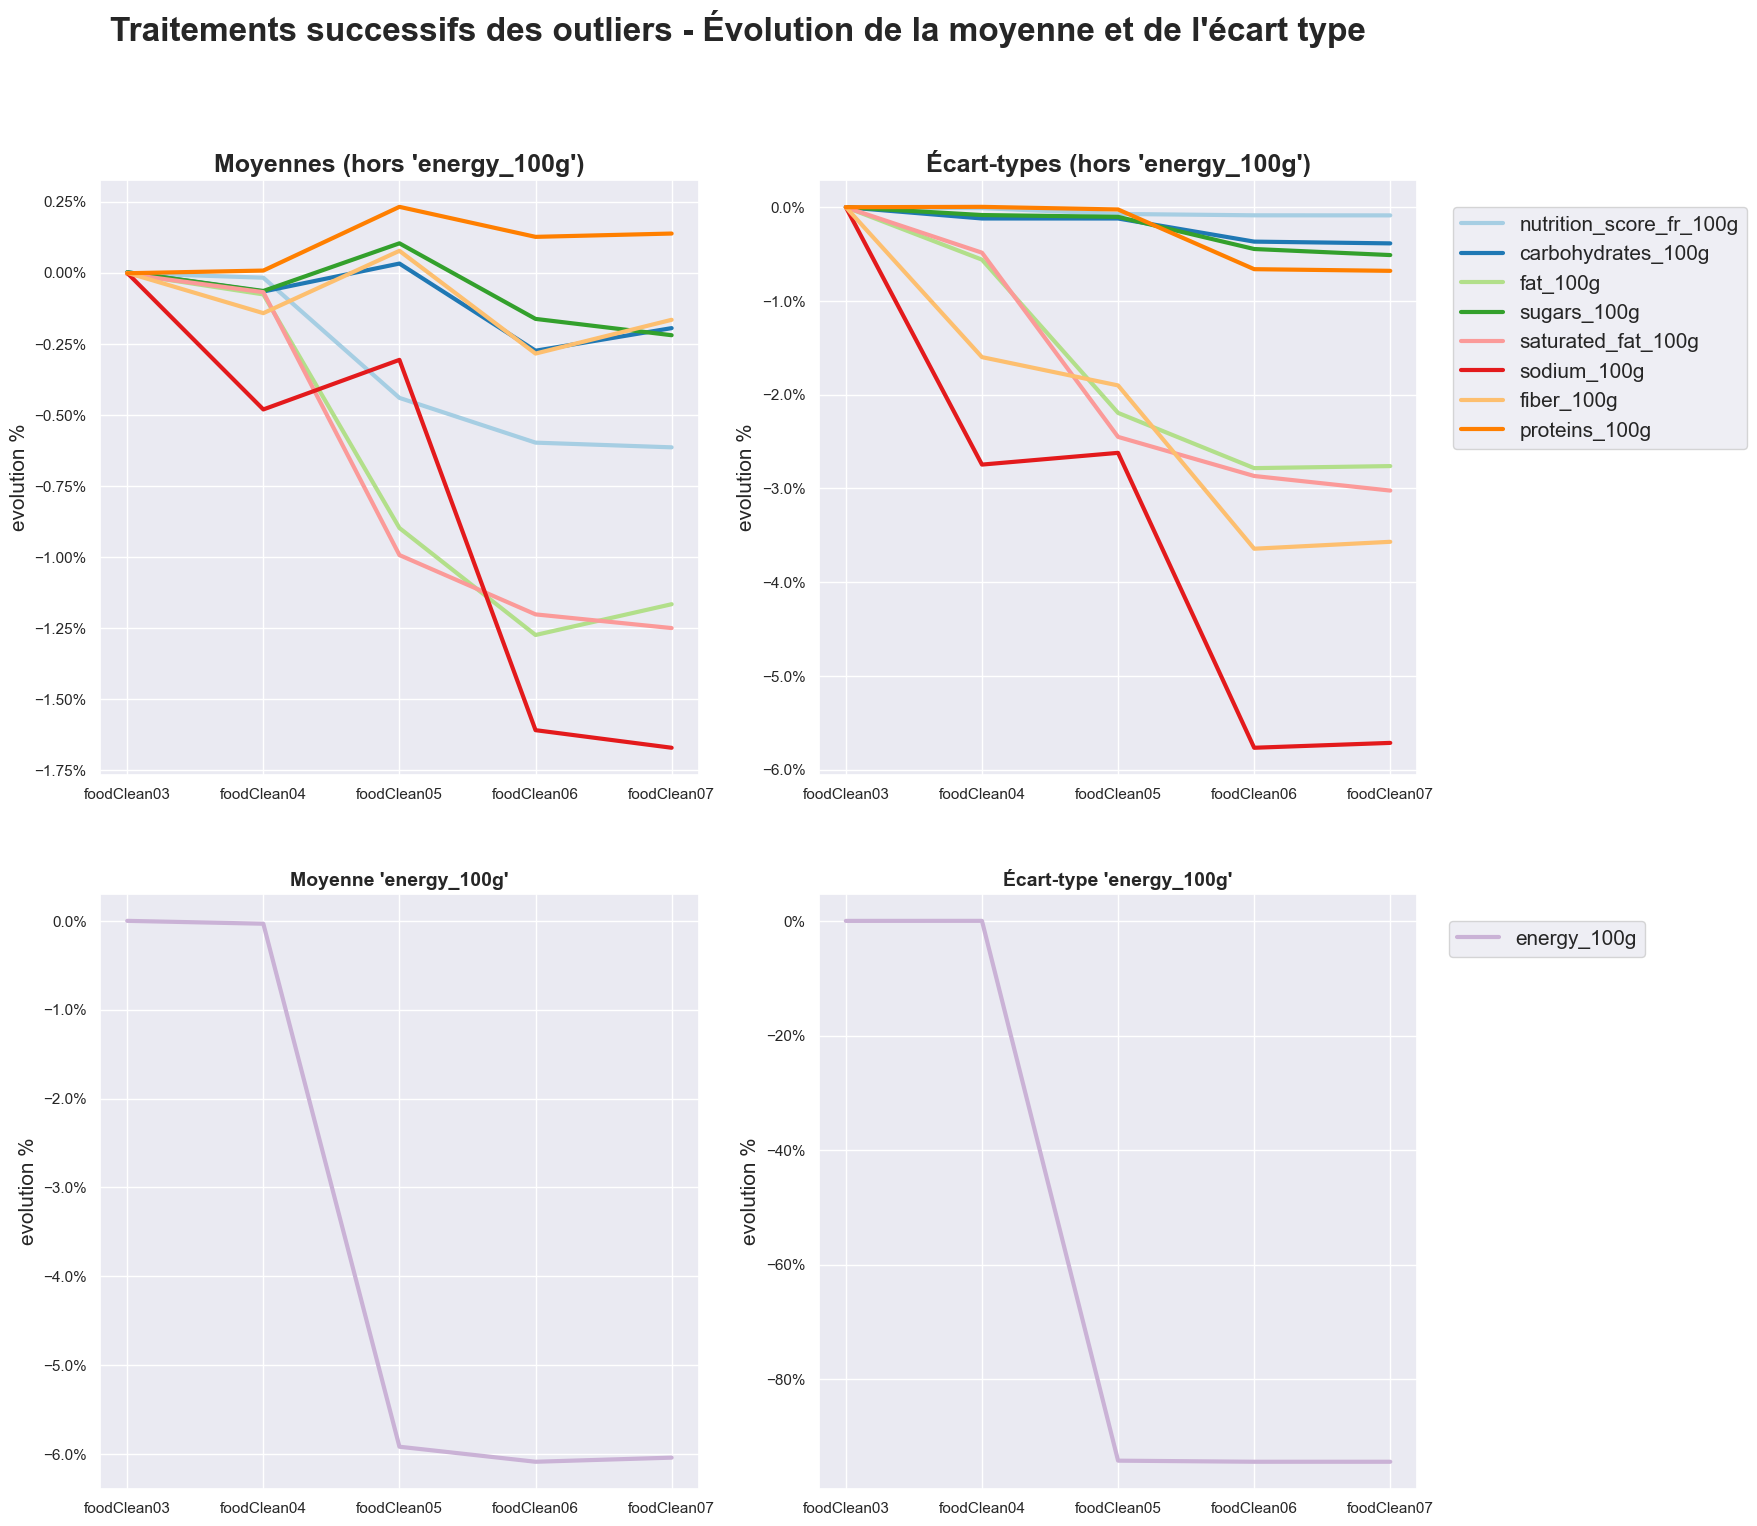

In [95]:
# visualisations of empirical mean and std evolution for each cleaning stage

palette=sns.color_palette("Paired") # set color palette
fig,axs=plt.subplots(2,2,sharex=False,figsize=(17,17)) # 4 plots 

axs=axs.reshape(axs.size) # reshape for easier iteration



for idxCol in range(len(numericalFeatureNames)) :
    
    if idxCol!=numericalFeatureNames.index("energy_100g") : # cleaning on "energy_100g" had more impact --> separate plots
        
        sns.lineplot(
            ax=axs[0],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfMean[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            palette=palette
        )
        
        sns.lineplot(
            ax=axs[1],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfStd[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            palette=palette
        )
        
    else :
        sns.lineplot(
            ax=axs[2],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfMean[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            color=palette[idxCol]
        )
        
        sns.lineplot(
            ax=axs[3],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfStd[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            color=palette[idxCol]
        )

# axs titles
axs[0].set_title("Moyennes (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[1].set_title("Écart-types (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[2].set_title("Moyenne 'energy_100g'", fontweight="bold",fontsize=14) 
axs[3].set_title("Écart-type 'energy_100g'", fontweight="bold",fontsize=14) 

# for each plot
for i in range(len(axs)) :
    axs[i].set_xticks([3,4,5,6,7]) # 1 tick for 1 cleaning stage 
    axs[i].set_xticklabels(["foodClean0"+str(i+3) for i in range(5)]) # name xticks with names of dataframes
    axs[i].set_ylabel("evolution %",fontsize=15) # set y label
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
    
fig.legend(numericalFeatureNames[:-1],bbox_to_anchor=(1.1,0.87),fontsize=15) # set legend - each numerical feature name...
legEnergy=fig.legend([numericalFeatureNames[-1]],bbox_to_anchor=(1.04,0.45),fontsize=15) # ... except for "energy_100g", on a different legend
legEnergy.legendHandles[0].set_color(palette[numericalFeatureNames.index("energy_100g")]) # choose the right color from the palette for energy legend
fig.suptitle("Traitements successifs des outliers - Évolution de la moyenne et de l'écart type", fontweight="bold",fontsize=24) # main title

plt.show()


Les différents étapes de nettoyage sur les outliers ont globalement :
- diminuer les moyennes empiriques des features numériques (mis à part "proteins_100g")
- diminuer les écart-types empririques

L'opération sur "energy_100g" (fixer une borne haute à 3700 KJ) a eu un impact très important.

## P2.4. Traiter les valeurs manquantes

### P2.4.x xxxattendre de voir si obligé de sup les rows en question , p-e que les knn et iterave les laisserons vides xxxx Traiter les valeurs manquantes - lignes complétement vides

Nous testerons plusieurs méthodes d'imputation des valeurs manquantes sur les features numériques :
- multivariées, avec l' Iterative Imputer ou le KNN Imputer
- univariée, avec une imputation par une valeur (comme la médiane de la feature en question)

L'imputation univariée est la solution de dernier recours, la moins précise.

### P2.4.1. Création d'un dataframe de test

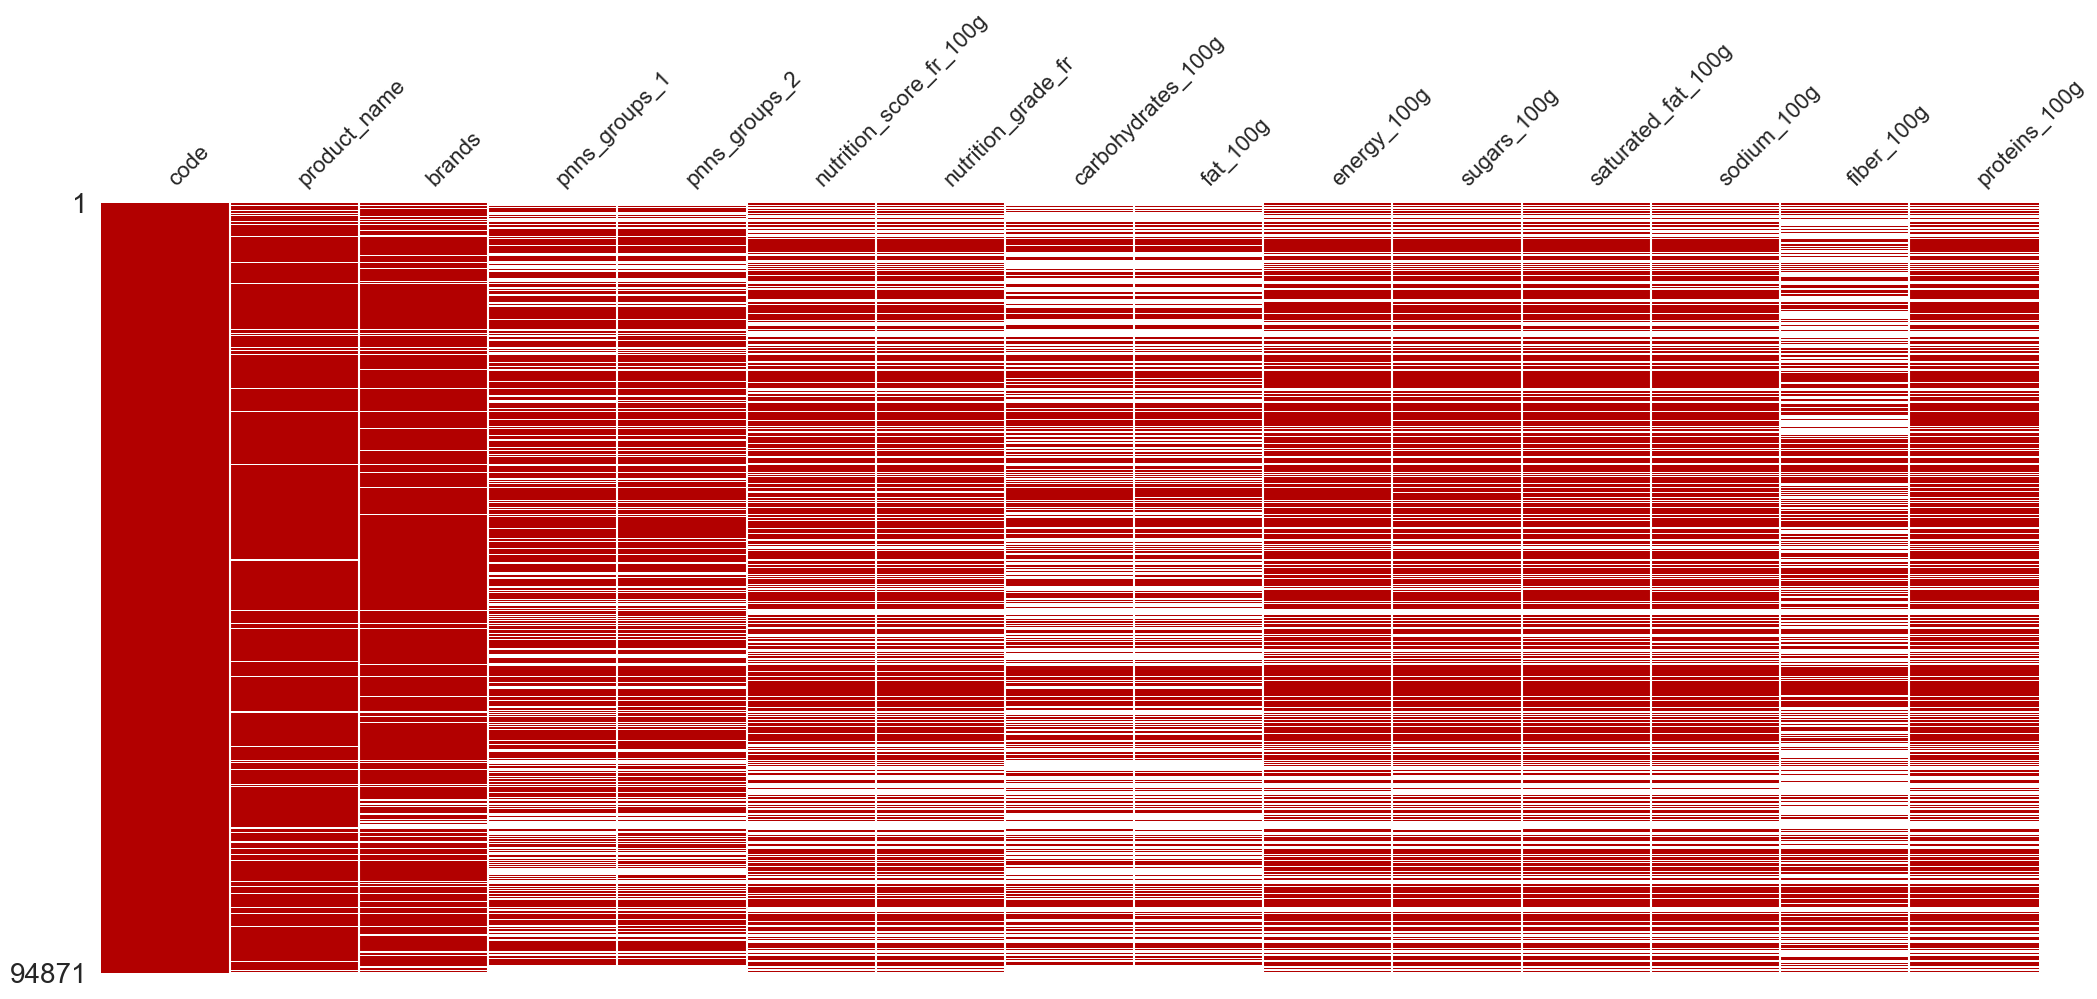

In [107]:
ms.matrix(foodClean07,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

In [122]:
foodComplete = foodClean07.copy()
foodComplete=foodComplete.loc[foodComplete.notna().all(axis=1)]

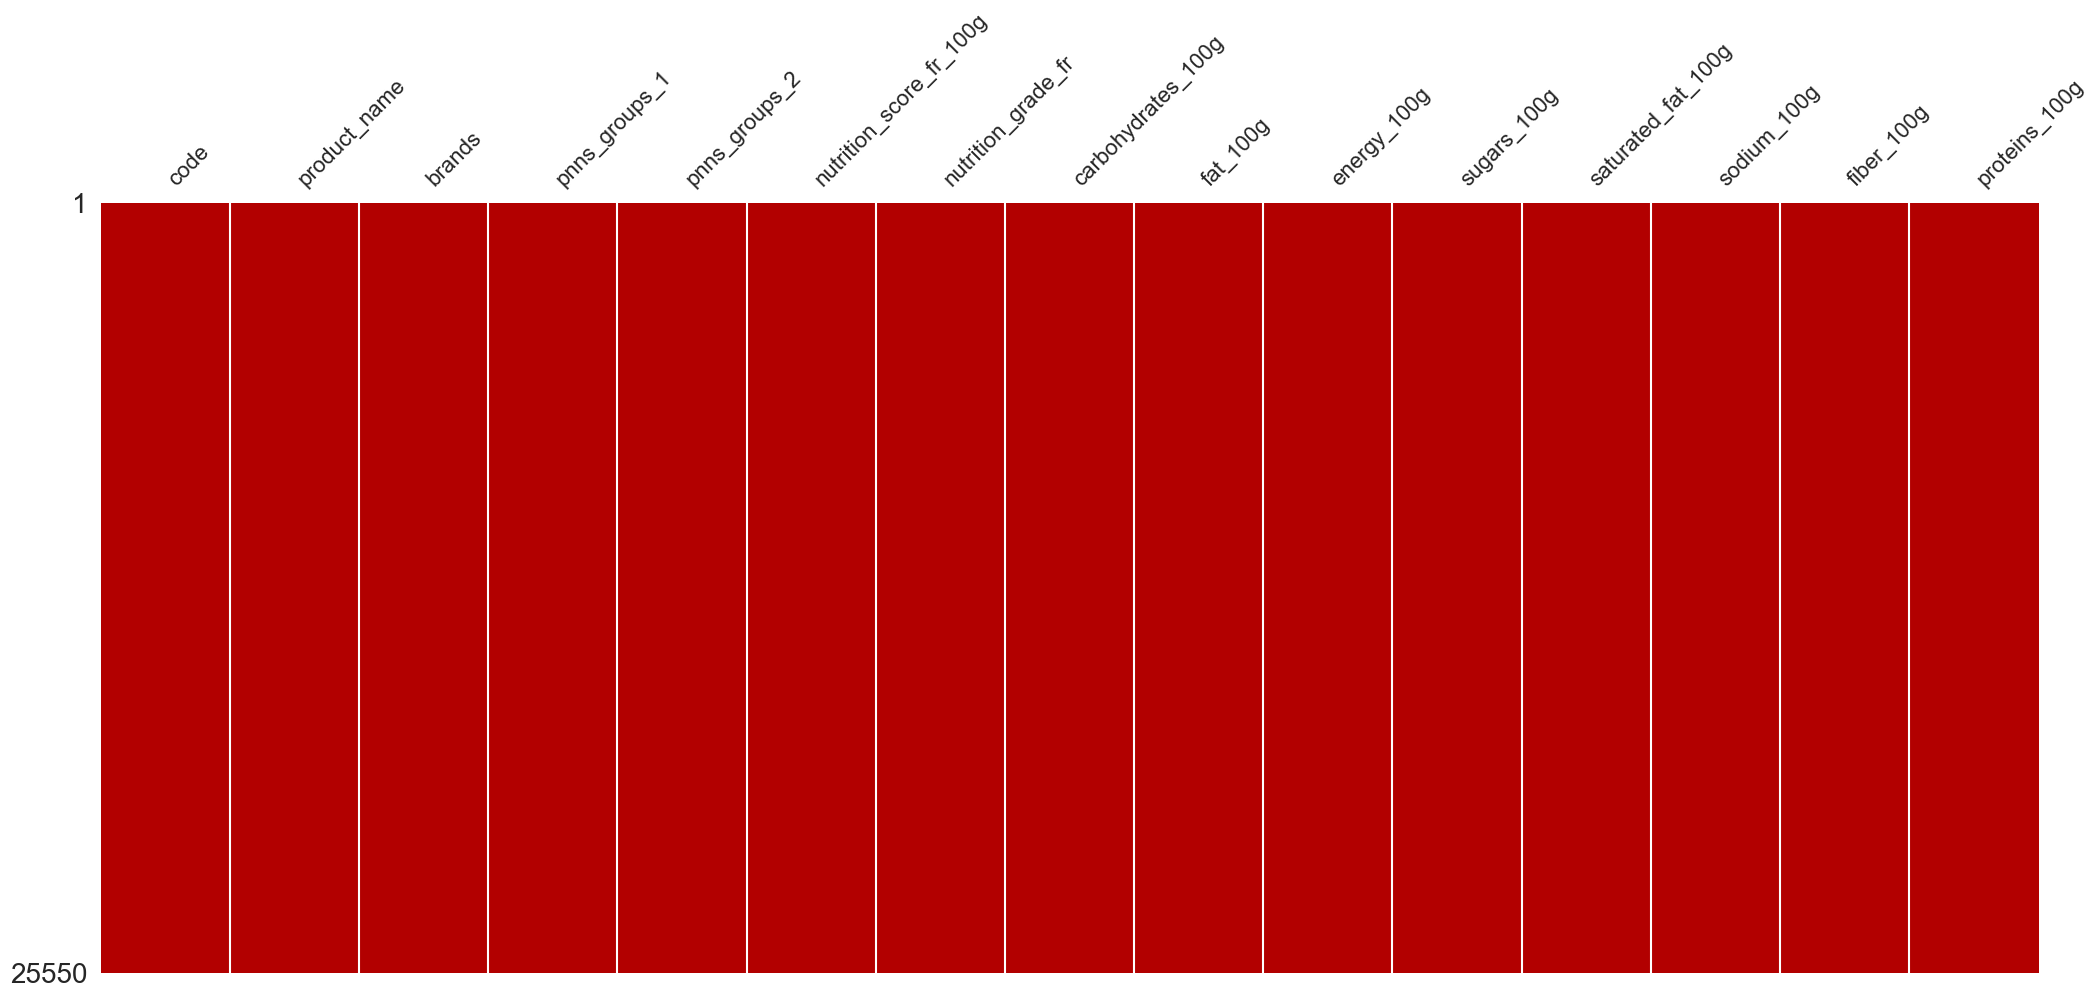

In [125]:
ms.matrix(foodComplete,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

In [141]:
# create null values

foodIncomplete = foodComplete.copy()
foodSoluce = foodComplete.copy()

for col in foodComplete.columns :
    fracCol=foodClean07[col].isna().mean()
    maskCol = foodComplete[col].sample(frac=fracCol).index
    foodIncomplete.loc[maskCol,col]=np.nan
    foodSoluce.loc[foodIncomplete[col].notna(),col]=np.nan
    

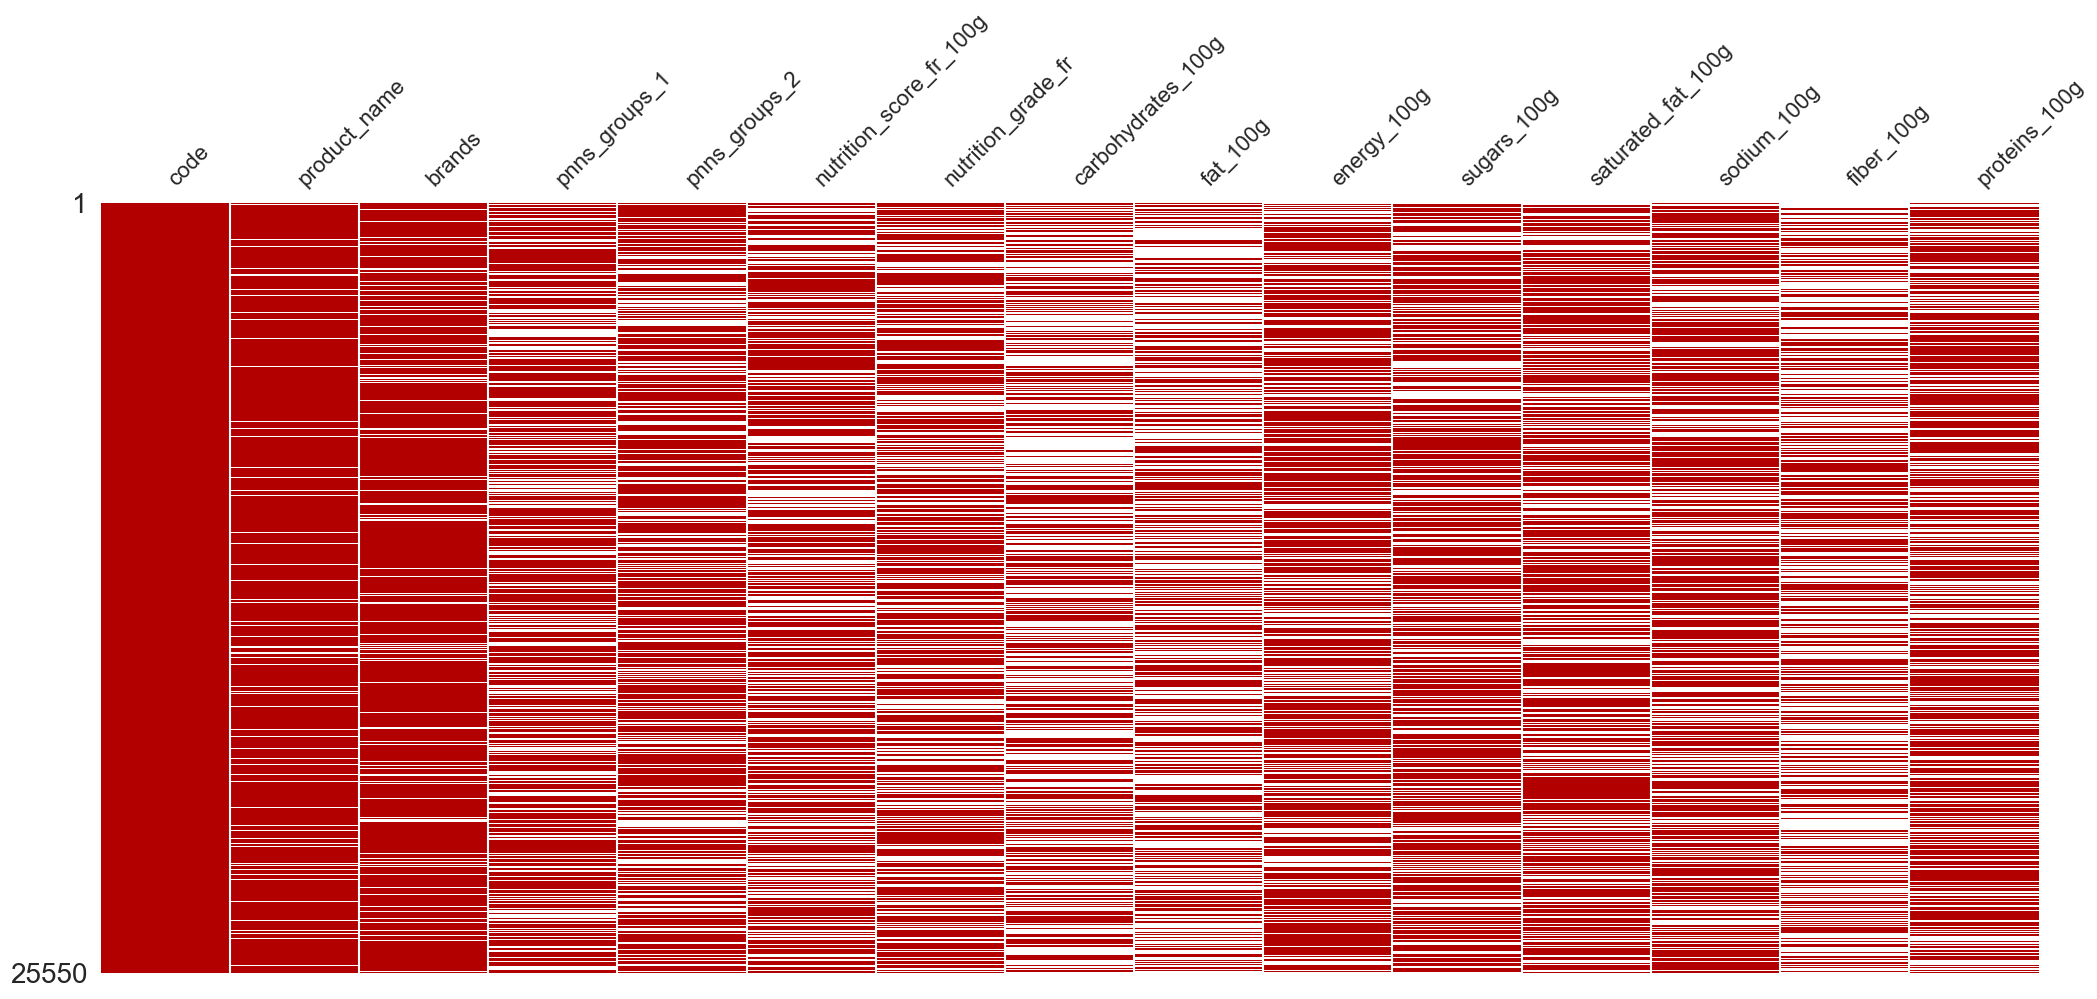

In [142]:
ms.matrix(foodIncomplete,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

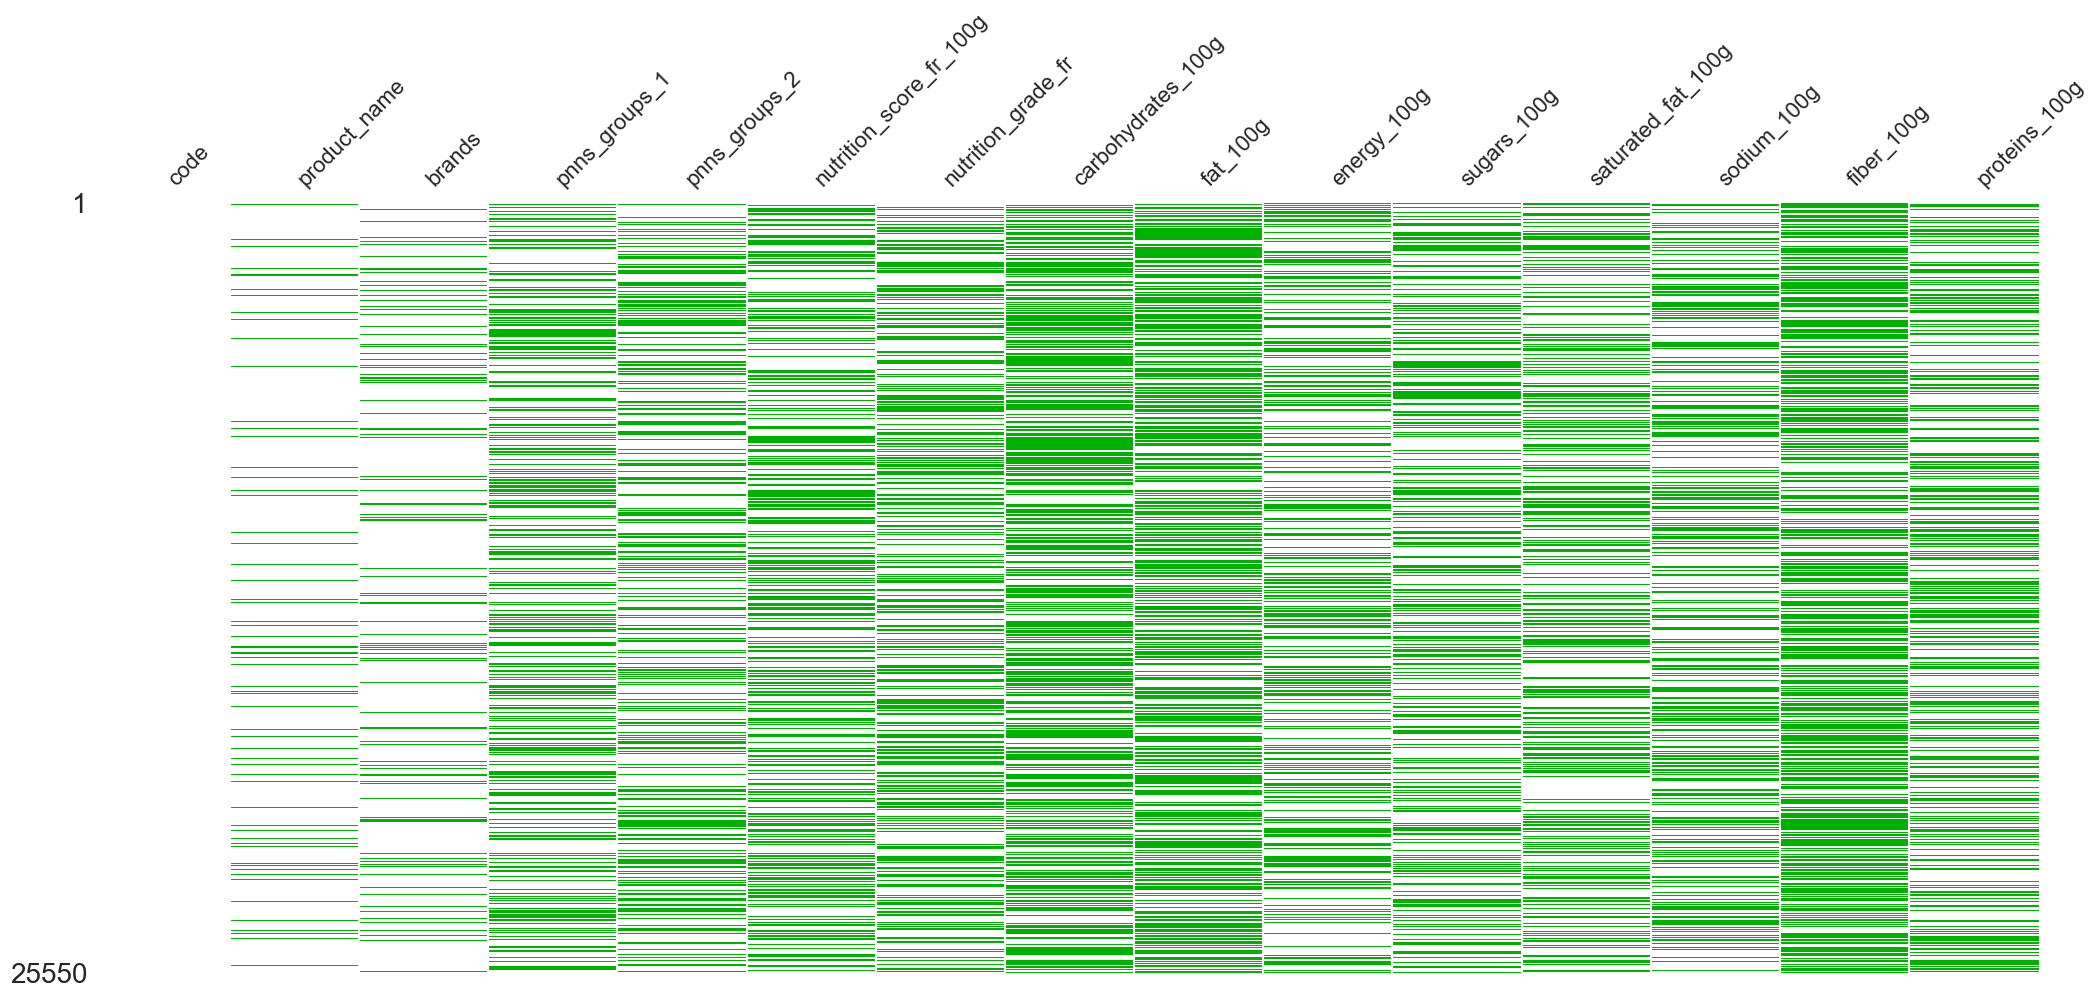

In [143]:
ms.matrix(foodSoluce,color=[0.0,0.7,0.0],sparkline=False) # dataviz of missing data
plt.show()

### P2.4.2. Méthode gros bourrin

In [144]:
# KNN pour les autres variables
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors=5,missing_values=np.nan)

foodGuess01=pd.DataFrame(KNN_imputer.fit_transform(foodIncomplete[numericalFeatureNames]),columns=numericalFeatureNames,index=foodIncomplete.index)
foodGuess01

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g,energy_100g
106,-4.2,70.00,7.12,22.64,0.66,0.140803,3.860,12.200,1883.0
226,13.0,19.06,0.06,4.98,0.00,0.010000,0.974,0.624,177.0
452,14.0,96.00,23.12,96.00,8.16,0.112661,1.560,9.560,1665.0
454,26.0,58.40,11.84,33.50,3.80,0.393701,1.300,5.500,2172.0
458,18.0,35.40,13.30,35.70,10.34,0.312724,5.960,6.100,1809.0
...,...,...,...,...,...,...,...,...,...
320670,10.0,46.64,2.10,68.00,1.20,0.023622,6.400,5.920,1300.6
320681,2.6,20.98,1.30,0.12,2.88,0.001969,2.621,5.228,1017.0
320702,8.4,95.31,43.88,0.10,1.28,0.672666,1.470,0.004,854.6
320751,-4.0,74.80,2.80,4.86,0.60,0.259953,4.560,13.000,1643.0


In [145]:
foodSoluce[numericalFeatureNames]

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g,energy_100g
106,22.0,NaN,20.0,57.5,12.50,0.038000,2.500,2.50,NaN
226,NaN,10.40,0.0,10.4,NaN,NaN,0.000,0.00,NaN
452,NaN,NaN,0.5,NaN,0.50,0.000000,0.100,0.90,NaN
454,NaN,NaN,29.1,NaN,17.00,NaN,NaN,NaN,NaN
458,NaN,70.20,NaN,NaN,7.00,0.326772,2.500,NaN,NaN
...,...,...,...,...,...,...,...,...,...
320670,NaN,79.00,NaN,NaN,NaN,NaN,NaN,5.70,1568.0
320681,4.0,95.87,NaN,NaN,1.28,NaN,0.005,0.04,NaN
320702,2.0,NaN,1.3,NaN,NaN,0.000394,NaN,NaN,1031.0
320751,NaN,NaN,NaN,2.6,NaN,0.267717,5.900,NaN,NaN


## P2.4. Traiter les valeurs manquantes - features numériques

### P2.4.1. Matrice des correlations

In [108]:
# Compute the correlation matrix
foodCorr=foodClean07.corr()
foodCorr

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
nutrition_score_fr_100g,1.000000,0.243805,0.589194,0.627838,0.454909,0.614072,0.125856,-0.132253,0.099868
carbohydrates_100g,0.243805,1.000000,-0.064499,0.535346,0.635776,-0.021330,-0.086345,0.251210,-0.132778
fat_100g,0.589194,-0.064499,1.000000,0.779243,0.013311,0.751117,0.012834,0.091199,0.157979
energy_100g,0.627838,0.535346,0.779243,1.000000,0.338417,0.576842,-0.021150,0.225445,0.220704
sugars_100g,0.454909,0.635776,0.013311,0.338417,1.000000,0.087480,-0.096281,0.029214,-0.252876
saturated_fat_100g,0.614072,-0.021330,0.751117,0.576842,0.087480,1.000000,0.004100,0.010166,0.151683
sodium_100g,0.125856,-0.086345,0.012834,-0.021150,-0.096281,0.004100,1.000000,-0.016647,0.093299
fiber_100g,-0.132253,0.251210,0.091199,0.225445,0.029214,0.010166,-0.016647,1.000000,0.191931
proteins_100g,0.099868,-0.132778,0.157979,0.220704,-0.252876,0.151683,0.093299,0.191931,1.000000


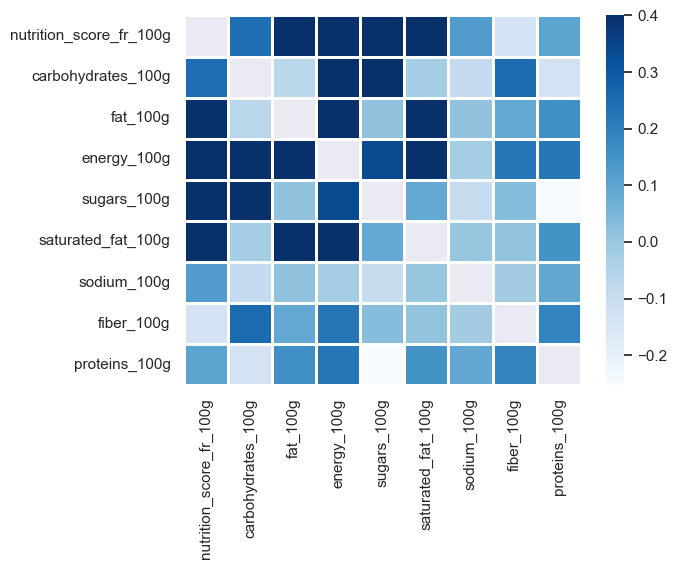

In [120]:
# Display the correlation matrix on a heatmap

# Generate a mask to display only the lower triangle
maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=1)
maskId = np.identity(len(foodCorr),dtype=bool)

# Draw the heatmap with the mask

sns.heatmap(
    data=foodCorr,
    mask=maskId,
    linewidth=1,
    cmap="Blues",
    vmax=0.4
    
);


**Le score nutritionnel étant la feature que l'application devra prédire pour calculer un MyHealthScore, nous n'allons pas réaliser d'opération d'imputation dessus. La préparation des données, objet du présent projet, pourra permettre d'alimenter les personnes en charge de la création de l'app.**

**Nous pouvons néanmoins nous en servir pour imputer les autres features.**

### P2.4.2. Deux groupes


### P2.4.3. Groupe 1 - les variables assez corrélées entre elles


In [ ]:
group1Features = ["nutrition"]

#### P2.4.3.1. Groupe 1 - création d'un échantillon de test


#### P2.4.3.2. Groupe 1 - test du iterative imputer


#### P2.4.3.3. Groupe 1 - test du KNN imputer


#### P2.4.3.4. Groupe 1 - test du simple imputer mixé avec pnns-2


#### P2.4.3.5. Groupe 1 - comparaison des résultats


#### P2.4.3.5. Groupe 1 - imputation


### P2.4.4. Groupe 2 - les variables peu corrélées entre elles


#### P2.4.4.1. Groupe 2 - création d'un échantillon de test


#### P2.4.4.2. Groupe 2 - test du iterative imputer


#### P2.4.4.3. Groupe 2 - test du KNN imputer


#### P2.4.4.4. Groupe 2 - test du simple imputer mixé avec pnns-2


#### P2.4.4.5. Groupe 2 - comparaison des résultats


#### P2.4.4.5. Groupe 2 - imputation


# Partie 3 - Exploration

# Tests -  score nutritionnel et nutrigrade

In [68]:
testNutri=foodClean02[["nutrition_grade_fr","nutrition_score_fr_100g"]].copy()
testNutri=testNutri.loc[testNutri.notna().any(axis=1)]
testNutri=testNutri.sort_values("nutrition_grade_fr")

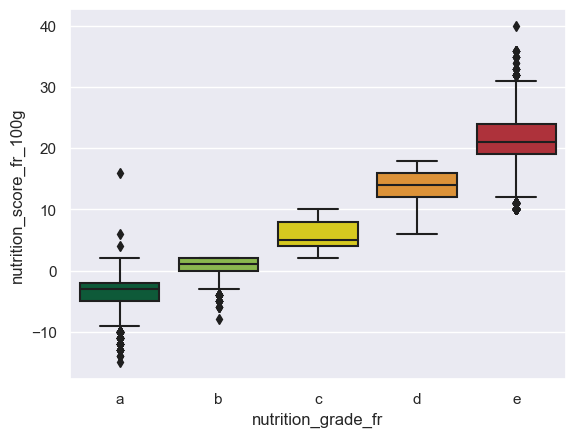

In [69]:
sns.set(style="darkgrid")
myPalette= {"a": "#02663B",
           "b": "#8DC83E",
           "c" : "#F4E300",
           "d" : "#F7941D",
           "e" : "#C31D2A",
           }
sns.boxplot(data=testNutri,x="nutrition_grade_fr",y="nutrition_score_fr_100g",palette=myPalette);

# Tests -  énergie et nutrigrade

In [70]:
testEnerNut=foodClean02[["nutrition_grade_fr","energy_100g"]].copy()

In [71]:
testEnerNut=testEnerNut.loc[testEnerNut.notna().any(axis=1)]
testEnerNut=testEnerNut.loc[testEnerNut["energy_100g"]<3700]
testEnerNut=testEnerNut.sort_values("nutrition_grade_fr")

<AxesSubplot:xlabel='nutrition_grade_fr', ylabel='energy_100g'>

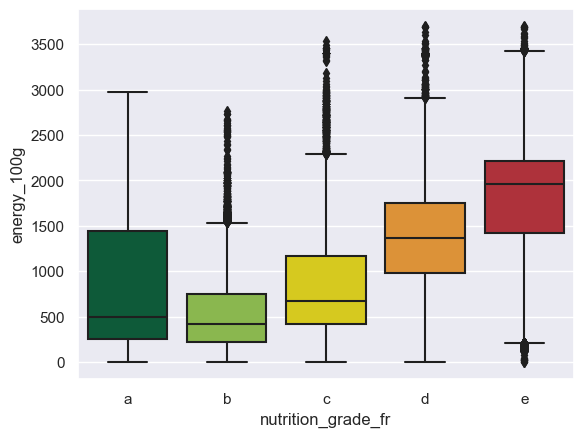

In [72]:
sns.boxplot(data=testEnerNut,x="nutrition_grade_fr",y="energy_100g",palette=myPalette)

# Tests -  énergie et nutrigrade

In [73]:
foodRaw.pnns_groups_2.value_counts()

unknown                             22624
One-dish meals                       5546
Sweets                               4698
Biscuits and cakes                   4561
Non-sugared beverages                4302
Cereals                              4106
Cheese                               4024
Dressings and sauces                 3602
Milk and yogurt                      3297
Processed meat                       3247
Chocolate products                   3109
Alcoholic beverages                  2909
Vegetables                           2840
Fish and seafood                     2638
Sweetened beverages                  2170
Appetizers                           2101
Fruits                               2068
Fruit juices                         1924
Bread                                1838
Meat                                 1694
Fats                                 1614
Breakfast cereals                    1408
vegetables                            934
Legumes                           

In [74]:
%pwd

'C:\\Users\\cleme\\OneDrive\\Documents\\8. TRAVAIL CLEMENT\\2.3. Reconversion Data\\1. OpenClassRooms\\2. Projets\\2.3. Préparez données pour organisme santé publique'